# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [138]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [139]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [140]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [141]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [142]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

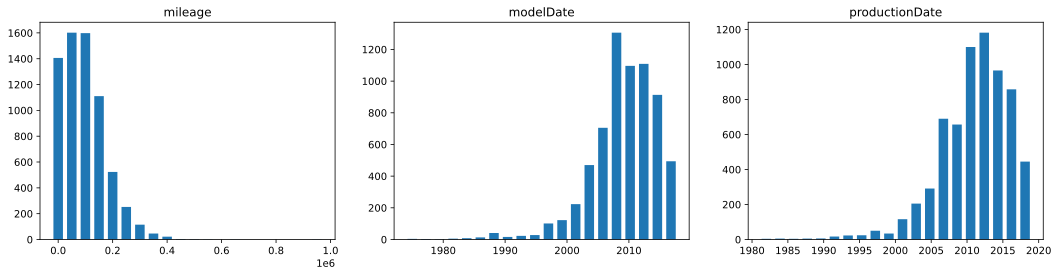

In [143]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [144]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [145]:
pd.set_option('display.max_columns', 25)
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [146]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [147]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

In [148]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    df_output.drop(['name', 'Владение'], axis = 1, inplace = True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [149]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,modelDate,productionDate,sample,price,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
1765,0.154999,0.895833,0.842105,1,1200000.0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1,0,1,0
2323,0.149999,0.833333,0.789474,1,1500000.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1,1,0
6686,0.094999,0.854167,0.815789,1,1990000.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0
7254,0.119999,0.833333,0.763158,1,930000.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1,1,0
1311,0.179999,0.708333,0.657895,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0
7090,0.209999,0.770833,0.763158,1,535000.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0,1,0
3369,0.024893,0.979167,0.973684,1,5750000.0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,1,0
7045,0.047999,0.750000,0.710526,1,990000.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1,1,0
5294,0.091760,0.791667,0.789474,1,790000.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0
5507,0.224999,0.645833,0.631579,1,400000.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0,1,0


In [150]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 388 entries, mileage to Руль_1
dtypes: float64(4), int64(1), uint8(383)
memory usage: 3.4 MB


## Split data

In [151]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [152]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 387 entries, mileage to Руль_1
dtypes: float64(4), uint8(383)
memory usage: 690.3 KB


# Model 2: CatBoostRegressor

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [165]:
model = CatBoostRegressor(iterations = 5000,
                          depth=10,
                          #learning_rate = 0.05,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9860579	test: 1.0104514	best: 1.0104514 (0)	total: 20.4ms	remaining: 1m 41s
100:	learn: 0.3053427	test: 0.3186885	best: 0.3186885 (100)	total: 2.52s	remaining: 2m 2s
200:	learn: 0.2420181	test: 0.2551408	best: 0.2551408 (200)	total: 4.87s	remaining: 1m 56s
300:	learn: 0.2034298	test: 0.2189578	best: 0.2189578 (300)	total: 7.07s	remaining: 1m 50s
400:	learn: 0.1802308	test: 0.1975457	best: 0.1975457 (400)	total: 8.93s	remaining: 1m 42s
500:	learn: 0.1679667	test: 0.1858661	best: 0.1858661 (500)	total: 10.9s	remaining: 1m 37s
600:	learn: 0.1565885	test: 0.1755799	best: 0.1755799 (600)	total: 13.2s	remaining: 1m 36s
700:	learn: 0.1489550	test: 0.1696217	best: 0.1696217 (700)	total: 15.2s	remaining: 1m 33s
800:	learn: 0.1430004	test: 0.1645517	best: 0.1645517 (800)	total: 17.2s	remaining: 1m 30s
900:	learn: 0.1376293	test: 0.1603967	best: 0.1603967 (900)	total: 19.2s	remaining: 1m 27s
1000:	learn: 0.1316873	test: 0.1557893	best: 0.1557893 (1000)	to

In [166]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.85%


In [168]:
df_preproc

,mileage,modelDate,productionDate,sample,price,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
0,0.349999,0.270833,0.236842,0,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0,1,0
1,0.014999,0.833333,0.815789,0,0.0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,1,1,0
2,0.166599,0.708333,0.684211,0,0.0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,1,1,0
3,0.146999,0.708333,0.657895,0,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0,1,0
4,0.023999,0.937500,0.973684,0,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,0.232776,0.708333,0.631579,1,550000.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0,1,0
8349,0.033699,0.875000,0.894737,1,1900000.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0,1,0
8350,0.199999,0.770833,0.684211,1,530000.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0,1,0
8351,0.071999,0.875000,0.894737,1,1970000.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0


### Submission

In [169]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [170]:
X_train.head(5)

,mileage,modelDate,productionDate,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,...,vehicleTransmission_3,Владельцы_-1,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.149999,0.770833,0.763158,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0,1,0
8037,0.020941,0.937500,0.947368,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,1,0
4681,0.133896,0.687500,0.631579,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1,1,0
6014,0.329999,0.729167,0.657895,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0,1,0
3649,0.125999,0.833333,0.815789,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1,1,0


## Simple Dense NN

In [171]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
#model.add(L.Dense(128, activation="relu"))
#model.add(L.Dropout(0.5))
#model.add(L.Dense(32, activation="relu"))
#model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [172]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 512)               198144    
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 257       
Total params: 329,729
Trainable params: 329,729
Non-trainable params: 0
_________________________________________________________________


In [173]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [174]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [175]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

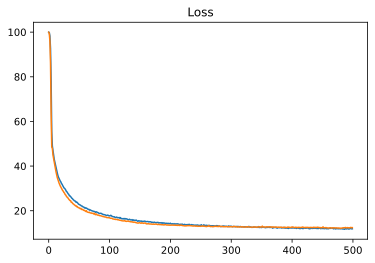

In [176]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [177]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [178]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.42%


In [179]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [180]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [181]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [182]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [183]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.67 s, sys: 3.14 ms, total: 1.67 s
Wall time: 1.67 s


In [184]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [185]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 2.92 s, sys: 40.3 ms, total: 2.96 s
Wall time: 3.08 s


In [186]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [187]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [188]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [189]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [190]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 256, 256)     525312      embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_24 (Dropout)            (None, 256, 256)     0           lstm_4[0][0]                     
_______________________________________________________________________________________

### Fit

In [191]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [192]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [193]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 458ms/step - loss: 99.9841 - MAPE: 99.9841 - val_loss: 99.8027 - val_MAPE: 99.8027
Epoch 2/500
12/12 [==============================] - 5s 390ms/step - loss: 98.2101 - MAPE: 98.2101 - val_loss: 91.7531 - val_MAPE: 91.7531
Epoch 3/500
12/12 [==============================] - 5s 390ms/step - loss: 74.1332 - MAPE: 74.1332 - val_loss: 48.8355 - val_MAPE: 48.8355
Epoch 4/500
12/12 [==============================] - 5s 392ms/step - loss: 50.9791 - MAPE: 50.9791 - val_loss: 45.2891 - val_MAPE: 45.2891
Epoch 5/500
12/12 [==============================] - 5s 400ms/step - loss: 45.6646 - MAPE: 45.6646 - val_loss: 41.5421 - val_MAPE: 41.5421
Epoch 6/500
12/12 [==============================] - 5s 390ms/step - loss: 41.3352 - MAPE: 41.3352 - val_loss: 38.2514 - val_MAPE: 38.2514
Epoch 7/500
12/12 [==============================] - 5s 396ms/step - loss: 38.0810 - MAPE: 38.0810 - val_loss: 35.0304 - val_MAPE: 35.0304
Epoch 8/500
12/12 [========

12/12 [==============================] - 4s 374ms/step - loss: 14.1810 - MAPE: 14.1810 - val_loss: 14.0703 - val_MAPE: 14.0703
Epoch 60/500
12/12 [==============================] - 5s 400ms/step - loss: 14.1160 - MAPE: 14.1160 - val_loss: 13.7906 - val_MAPE: 13.7906
Epoch 61/500
12/12 [==============================] - 5s 388ms/step - loss: 14.0111 - MAPE: 14.0111 - val_loss: 13.9960 - val_MAPE: 13.9960
Epoch 62/500
12/12 [==============================] - 5s 390ms/step - loss: 13.9145 - MAPE: 13.9145 - val_loss: 13.8345 - val_MAPE: 13.8345
Epoch 63/500
12/12 [==============================] - 4s 371ms/step - loss: 13.7716 - MAPE: 13.7716 - val_loss: 13.6691 - val_MAPE: 13.6691
Epoch 64/500
12/12 [==============================] - 5s 389ms/step - loss: 13.5475 - MAPE: 13.5475 - val_loss: 13.6440 - val_MAPE: 13.6440
Epoch 65/500
12/12 [==============================] - 4s 366ms/step - loss: 13.6709 - MAPE: 13.6709 - val_loss: 13.5577 - val_MAPE: 13.5577
Epoch 66/500
12/12 [=============

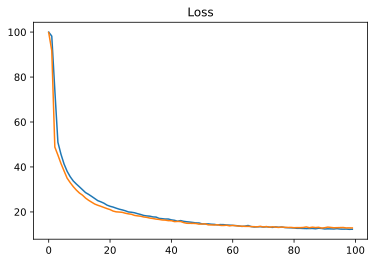

In [194]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [195]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [196]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.86%


In [197]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

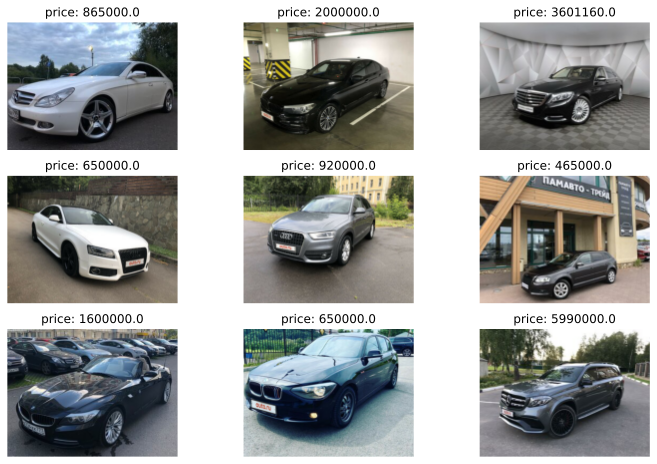

In [198]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [199]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

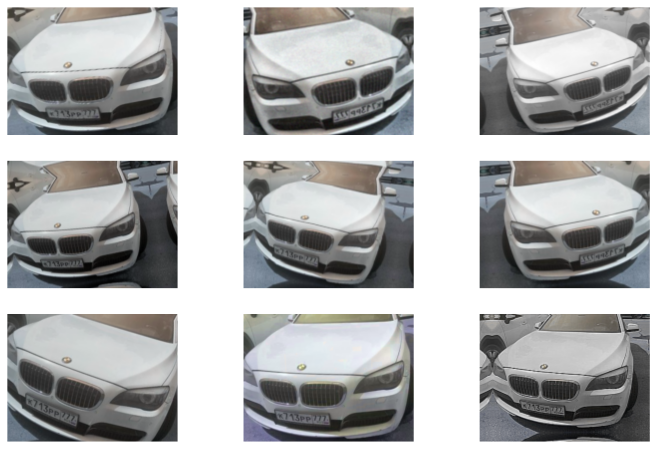

In [200]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [203]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

IndentationError: expected an indented block (<ipython-input-203-5b968865d80f>, line 6)

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [63]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [64]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [65]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 1s 0us/step


In [66]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [67]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [68]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [69]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [70]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [71]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 147s 774ms/step - loss: 52.9240 - MAPE: 52.9240 - val_loss: 70.1370 - val_MAPE: 70.1370
Epoch 2/100
190/190 [==============================] - 146s 767ms/step - loss: 28.1169 - MAPE: 28.1169 - val_loss: 23.8405 - val_MAPE: 23.8405
Epoch 3/100
190/190 [==============================] - 144s 756ms/step - loss: 22.2156 - MAPE: 22.2156 - val_loss: 20.0819 - val_MAPE: 20.0819
Epoch 4/100
190/190 [==============================] - 145s 764ms/step - loss: 19.4494 - MAPE: 19.4494 - val_loss: 18.6622 - val_MAPE: 18.6622
Epoch 5/100
190/190 [==============================] - 143s 755ms/step - loss: 18.1086 - MAPE: 18.1086 - val_loss: 17.4437 - val_MAPE: 17.4437
Epoch 6/100
190/190 [==============================] - 142s 745ms/step - loss: 16.9900 - MAPE: 16.9900 - val_loss: 17.6042 - val_MAPE: 17.6042
Epoch 7/100
190/190 [==============================] - 144s 758ms/step - loss: 15.8052 - MAPE: 15.8052 - val_loss: 17.7990 - val_MAPE: 17.7990

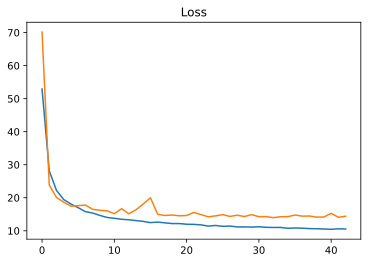

In [72]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [73]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [74]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 14.41%


In [75]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [76]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 12.30%


In [77]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [78]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [79]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [80]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [81]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_13_input (InputLayer)     [(None, 1543)]       0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          790528      dense_13_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [82]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [83]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 27ms/step - loss: 99.9910 - MAPE: 99.9910 - val_loss: 99.8799 - val_MAPE: 99.8799
Epoch 2/500
12/12 [==============================] - 0s 12ms/step - loss: 98.7330 - MAPE: 98.7330 - val_loss: 93.8702 - val_MAPE: 93.8702
Epoch 3/500
12/12 [==============================] - 0s 12ms/step - loss: 78.8047 - MAPE: 78.8047 - val_loss: 49.7466 - val_MAPE: 49.7466
Epoch 4/500
12/12 [==============================] - 0s 14ms/step - loss: 52.3172 - MAPE: 52.3172 - val_loss: 45.3727 - val_MAPE: 45.3727
Epoch 5/500
12/12 [==============================] - 0s 13ms/step - loss: 45.3113 - MAPE: 45.3113 - val_loss: 41.3032 - val_MAPE: 41.3032
Epoch 6/500
12/12 [==============================] - 0s 12ms/step - loss: 40.5180 - MAPE: 40.5180 - val_loss: 37.1476 - val_MAPE: 37.1476
Epoch 7/500
12/12 [==============================] - 0s 12ms/step - loss: 36.7870 - MAPE: 36.7870 - val_loss: 33.3816 - val_MAPE: 33.3816
Epoch 8/500
12/12 [===============

12/12 [==============================] - 0s 12ms/step - loss: 14.1083 - MAPE: 14.1083 - val_loss: 15.6074 - val_MAPE: 15.6074
Epoch 61/500
12/12 [==============================] - 0s 12ms/step - loss: 13.5093 - MAPE: 13.5093 - val_loss: 15.6733 - val_MAPE: 15.6733
Epoch 62/500
12/12 [==============================] - 0s 11ms/step - loss: 13.6900 - MAPE: 13.6900 - val_loss: 15.8100 - val_MAPE: 15.8100
Epoch 63/500
12/12 [==============================] - 0s 12ms/step - loss: 13.6963 - MAPE: 13.6963 - val_loss: 15.6264 - val_MAPE: 15.6264
Epoch 64/500
12/12 [==============================] - 1s 103ms/step - loss: 13.6455 - MAPE: 13.6455 - val_loss: 15.5004 - val_MAPE: 15.5004
Epoch 65/500
12/12 [==============================] - 0s 12ms/step - loss: 13.4062 - MAPE: 13.4062 - val_loss: 15.5737 - val_MAPE: 15.5737
Epoch 66/500
12/12 [==============================] - 0s 12ms/step - loss: 13.4584 - MAPE: 13.4584 - val_loss: 15.7135 - val_MAPE: 15.7135
Epoch 67/500
12/12 [===================

Epoch 119/500
12/12 [==============================] - 0s 12ms/step - loss: 11.7874 - MAPE: 11.7874 - val_loss: 14.7770 - val_MAPE: 14.7770
Epoch 120/500
12/12 [==============================] - 0s 12ms/step - loss: 11.8251 - MAPE: 11.8251 - val_loss: 14.9780 - val_MAPE: 14.9780
Epoch 121/500
12/12 [==============================] - 0s 12ms/step - loss: 11.8618 - MAPE: 11.8618 - val_loss: 14.7966 - val_MAPE: 14.7966
Epoch 122/500
12/12 [==============================] - 0s 12ms/step - loss: 11.7544 - MAPE: 11.7544 - val_loss: 14.6704 - val_MAPE: 14.6704
Epoch 123/500
12/12 [==============================] - 0s 11ms/step - loss: 11.9308 - MAPE: 11.9308 - val_loss: 14.7796 - val_MAPE: 14.7796
Epoch 124/500
12/12 [==============================] - 0s 11ms/step - loss: 11.7427 - MAPE: 11.7427 - val_loss: 14.7085 - val_MAPE: 14.7085
Epoch 125/500
12/12 [==============================] - 0s 11ms/step - loss: 11.6835 - MAPE: 11.6835 - val_loss: 14.7030 - val_MAPE: 14.7030
Epoch 126/500
12/12 

In [84]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 14.79%


In [ ]:
# 